In [2]:
from __future__ import print_function
from pixell import enmap,utils, reproject, enplot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os,sys
import urllib.request
from scipy import interpolate
from astropy.table import QTable
import astropy.units as u
from astropy.io import fits
import csv
import yaml
from scipy.stats import norm
import matplotlib.patheffects as path_effects
import pickle as pk
from matplotlib.ticker import Locator
%matplotlib inline


In [3]:
def tileFinder(ra, dec, data):
    #Given an RA and Dec in deg, find the S18d tile containing that RA and Dec
    for i, tile in enumerate(data):
        box = tile['RADecSection']
        if box[0] >= box[1]:
            if (360 >= ra >= box[0] or 0 <= ra <box[1]) and box[2]<=dec<= box[3]:
                return tile['tileName']
        if box[0]<=ra<=box[1] and box[2]<=dec<= box[3]:
            return tile['tileName']
    return None

In [4]:
def s18dStamp(ra, dec, data, name, width = 0.5, write = True):
    #Find tile corresponding to RA, Dec
    path = '/project/r/rbond/jorlo/S18d_202006/filteredMaps/'
    tileName = tileFinder(ra, dec, data)
    if tileName == None: return None
    tile = enmap.read_map(path+tileName+'/Arnaud_M2e14_z0p4#'+tileName+'_filteredMap.fits')
    
    
    stamp = reproject.postage_stamp(tile, ra, dec, width*60, 0.5)
    if write:
        stamp.wcs.wcs.crval = [ra,dec]
        enmap.write_map('./for_tony/{}.fits'.format(name), stamp)
    return stamp

0
38


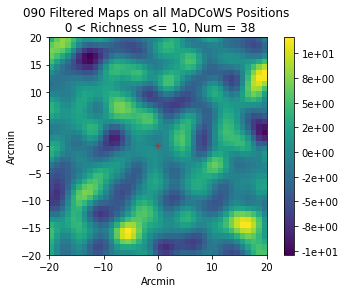

10
342


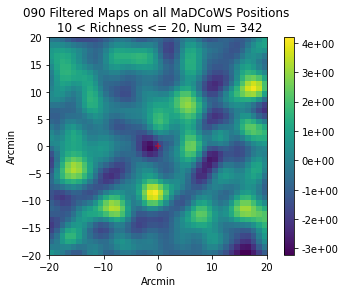

20
715


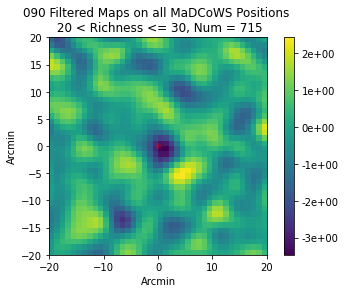

30
481


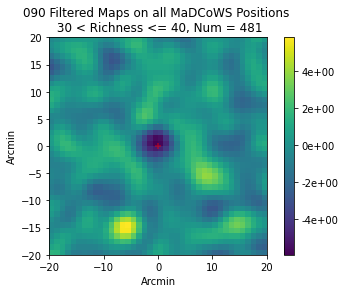

40
202


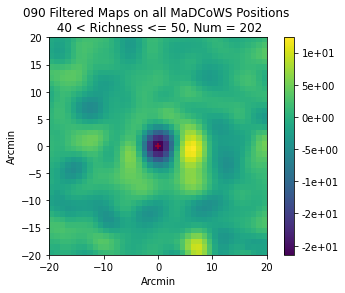

50
69


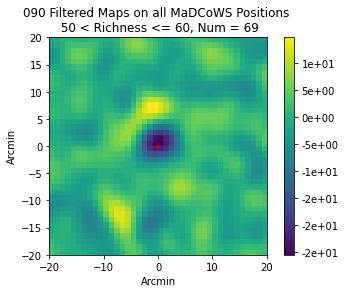

60
15


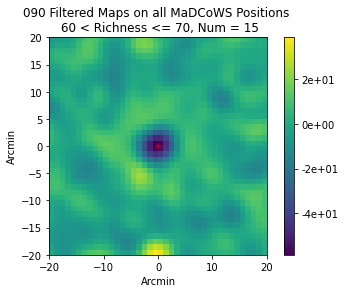

0
38


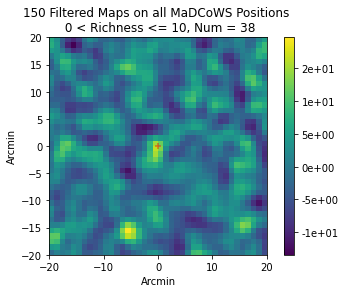

10
342


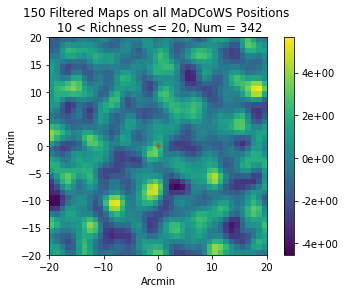

20
715


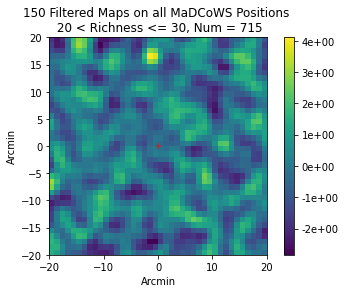

30
481


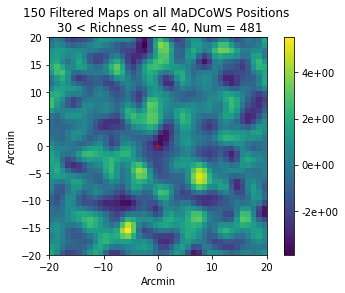

40
202


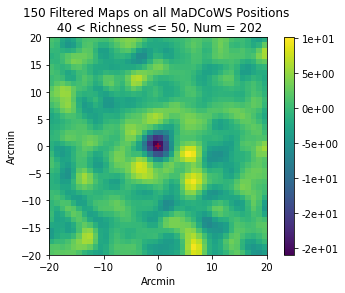

50
69


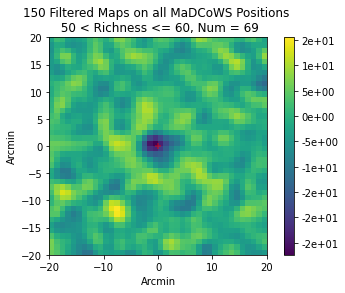

60
15


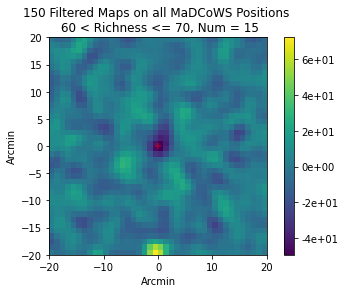

0
38


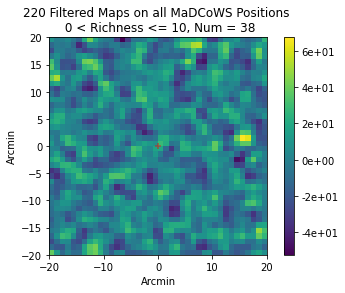

10
342


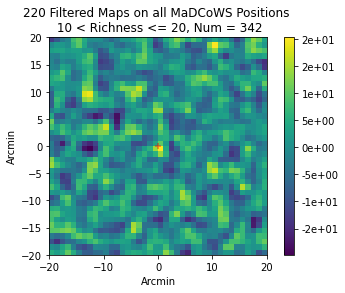

20
715


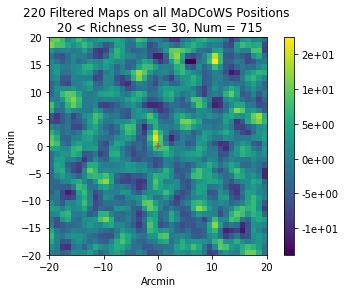

30
481


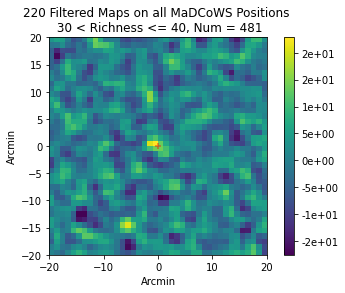

40
202


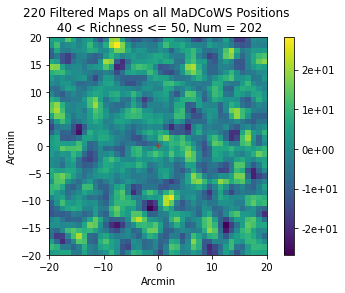

50
69


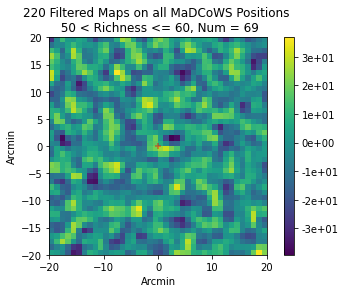

60
15


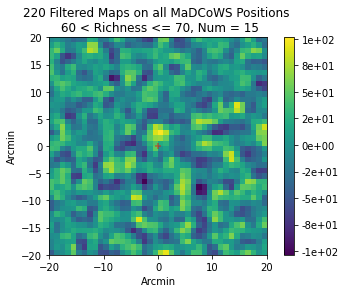

In [5]:
mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')

ra = mdcw_catalog[1].data['RADeg']
names = mdcw_catalog[1].data['name']
dec = mdcw_catalog[1].data['decDeg']
ra, dec = np.array(ra), np.array(dec)
rich = mdcw_catalog[1].data['Rich']
z = mdcw_catalog[1].data['Photz']

mdcw_freq_dict = {'090':{}, '150':{}, '220':{}}


for i, (freq, cur_dict) in enumerate(mdcw_freq_dict.items()):    
    
    cur_dict['central_t'] = []
    cur_dict['highest_t'] = []
    cur_dict['map_var'] = []
    
    cur_map = enmap.read_map('/gpfs/fs0/project/r/rbond/jorlo/freq_maps/stitched_Beam{}_filteredMap.fits'.format(str(freq)))
    
    for j in range(0,70, 10):
        print(j)
        
        flag = np.where((rich>j) & (rich<=j+10))[0]
        print(len(flag))
        if len(flag) == 0: continue

        ra_temp, dec_temp = ra[flag], dec[flag]

        stack = 0
        divisor = 0

        for k in range(len(ra_temp)):
            stamp = reproject.postage_stamp(cur_map, ra_temp[k], dec_temp[k], 20., 0.5)
            if stamp is None: continue
            stack += stamp[0]
            divisor += 1

        stack /= divisor

        plot = plt.imshow(stack, extent = [-20, 20, -20, 20])
        plt.scatter(0,0, marker = '+', color = 'r', alpha = 0.5)
        plt.colorbar(plot, format='%.0e')
        plt.title('{} Filtered Maps on all MaDCoWS Positions \n {} < Richness <= {}, Num = {}'.format(freq,j, j+10,len(flag)))

        plt.xlabel('Arcmin')
        plt.ylabel('Arcmin')
        plt.savefig('./plots/PS_freq/mdcw_{}_{}_{}_filtered_mdcw.pdf'.format(j, j+10, freq))
        plt.savefig('./plots/PS_freq/mdcw_{}_{}_{}_filtered_mdcw.png'.format(j, j+10,freq), dpi = 300)
        plt.show()
        plt.close()

        cur_dict['highest_t'].append(np.amin(stack[19:31,19:31]))
        cur_dict['central_t'].append(np.mean(stack[19:21, 19:21]))

        cur_dict['map_var'].append(np.sqrt(np.var(stack[0:15, 0:15])))

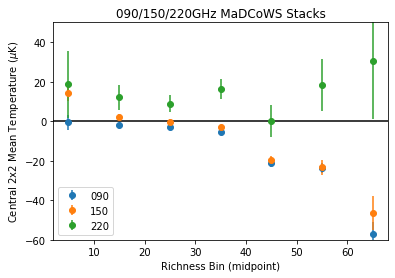

In [13]:
xrange = range(5,75, 10)
    
for i, (freq, cur_dict) in enumerate(mdcw_freq_dict.items()):    
    #print(len(cur_dict['map_var']))
    plt.errorbar(xrange, cur_dict['central_t'], yerr = cur_dict['map_var'], label = freq,fmt='--o', linestyle = 'none')
    #plt.plot(xrange, cur_dict['central_t'])
plt.legend(loc = 3)
plt.title(r'090/150/220GHz MaDCoWS Stacks')
plt.xlabel('Richness Bin (midpoint)')
plt.ylabel(r'Central 2x2 Mean Temperature ($\mu$K)')
plt.ylim(-60,50)
plt.axhline(y=0, color='k')

plt.savefig('./plots/PS_freq/mdcw_rich_central_temp.pdf')
plt.savefig('./plots/PS_freq/mdcw_rich_central_temp.png', dpi = 300)
plt.show()
plt.close()


# ACT Cluster Freq. Stacking

0
700


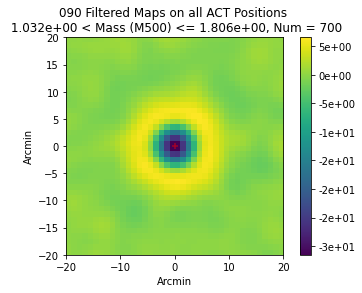

1
701


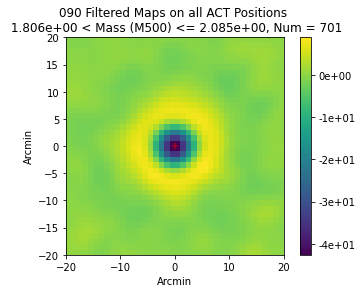

2
701


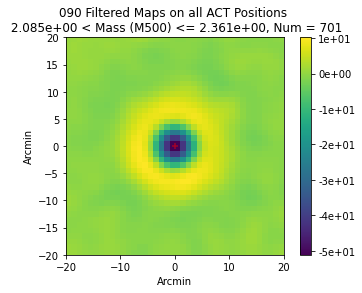

3
700


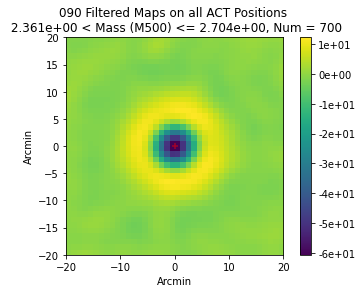

4
694


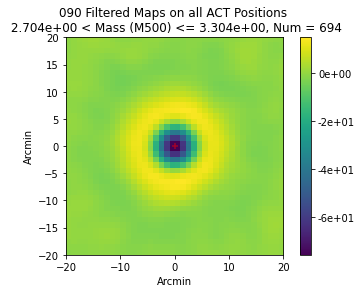

5
699


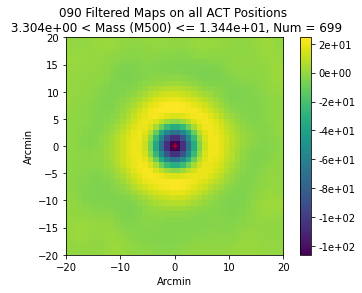

0
700


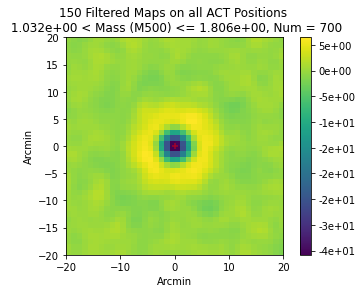

1
701


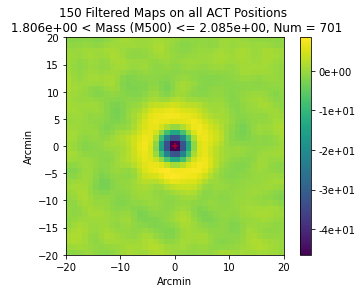

2
701


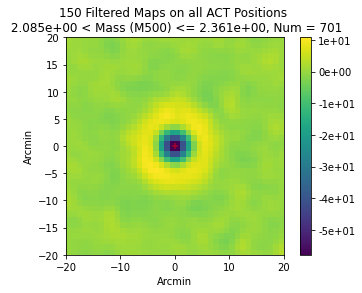

3
700


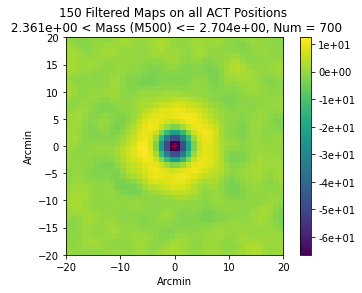

4
694


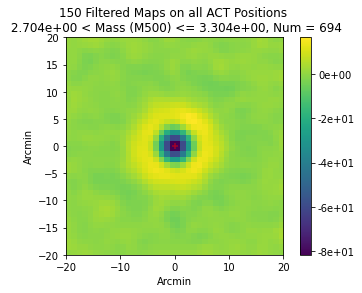

5
699


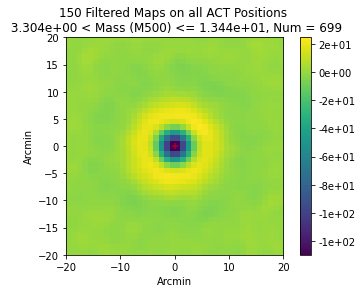

0
700


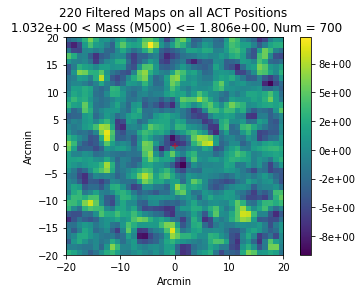

1
701


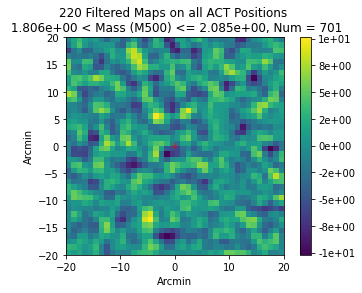

2
701


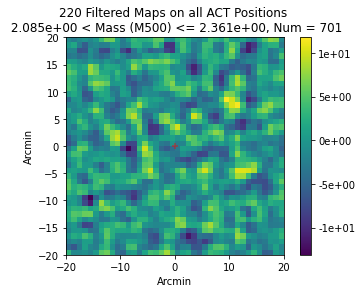

3
700


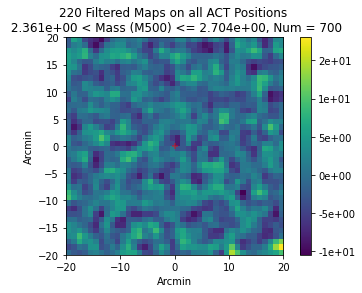

4
694


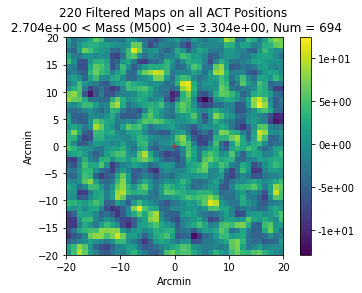

5
699


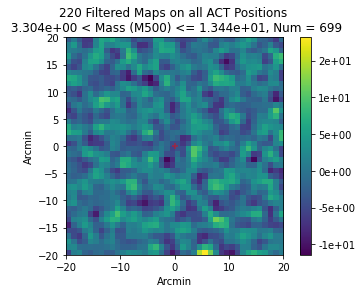

In [9]:
act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')

ra = act_catalog[1].data['RADeg']
names = act_catalog[1].data['name']
dec = act_catalog[1].data['decDeg']
ra, dec = np.array(ra), np.array(dec)
mass = act_catalog[1].data['M500']

nbins = 6
perc = np.percentile(mass, np.linspace(0,100, nbins+1)) 

perc[0] = perc[0]*0.99

act_freq_dict = {'090':{}, '150':{}, '220':{}}

for i, (freq, cur_dict) in enumerate(act_freq_dict.items()):    
    
    cur_dict['central_t'] = []
    cur_dict['highest_t'] = []
    cur_dict['map_var'] = []
    
    cur_map = enmap.read_map('/gpfs/fs0/project/r/rbond/jorlo/freq_maps/stitched_Beam{}_filteredMap.fits'.format(str(freq)))
    
    for j in range(nbins):
        print(j)
        flag = np.where((mass>perc[j]) & (mass<=perc[j+1]))[0]
        print(len(flag))
        if len(flag) == 0: continue

        ra_temp, dec_temp = ra[flag], dec[flag]

        stack = 0
        divisor = 0

        for k in range(len(ra_temp)):
            stamp = reproject.postage_stamp(cur_map, ra_temp[k], dec_temp[k], 20., 0.5)
            if stamp is None: continue
            stack += stamp[0]
            divisor += 1

        stack /= divisor

        plot = plt.imshow(stack, extent = [-20, 20, -20, 20])
        plt.scatter(0,0, marker = '+', color = 'r', alpha = 0.5)
        plt.colorbar(plot, format='%.0e')
        plt.title('{} Filtered Maps on all ACT Positions \n {:0.3e} < Mass (M500) <= {:0.3e}, Num = {}'.format(freq,perc[j], perc[j+1],len(flag)))

        plt.xlabel('Arcmin')
        plt.ylabel('Arcmin')
        plt.savefig('./plots/PS_freq/act_{}_{}_filtered_mdcw.pdf'.format(j, freq))
        plt.savefig('./plots/PS_freq/act_{}_{}_filtered_mdcw.png'.format(j, freq), dpi = 300)
        plt.show()
        plt.close()

        cur_dict['highest_t'].append(np.amin(stack[19:31,19:31]))
        cur_dict['central_t'].append(np.mean(stack[19:21, 19:21]))

        cur_dict['map_var'].append(np.sqrt(np.var(stack[0:15, 0:15])))

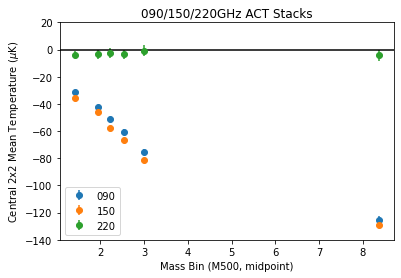

In [11]:
xrange = []
for i in range(nbins):
    xrange.append((perc[i]+perc[i+1])/2)
for i, (freq, cur_dict) in enumerate(act_freq_dict.items()):
    plt.errorbar(xrange, cur_dict['central_t'], yerr = cur_dict['map_var'], label = freq, linestyle = 'none', fmt='--o')
plt.legend()
plt.title(r'090/150/220GHz ACT Stacks')
plt.xlabel('Mass Bin (M500, midpoint)')
plt.ylabel(r'Central 2x2 Mean Temperature ($\mu$K)')
plt.axhline(y=0, color='k')
plt.ylim(-140, 20)

plt.savefig('./plots/PS_freq/act_rich_central_temp.pdf')
plt.savefig('./plots/PS_freq/act_rich_central_temp.png', dpi = 300)
plt.show()
plt.close()


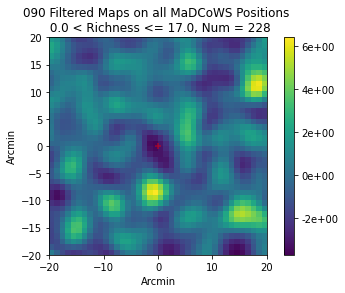

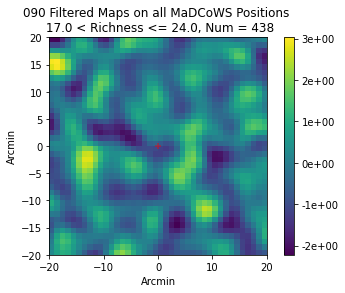

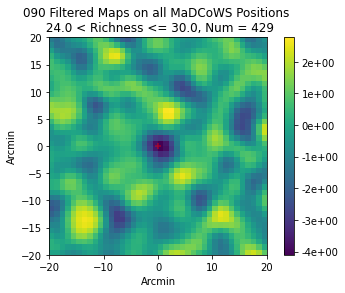

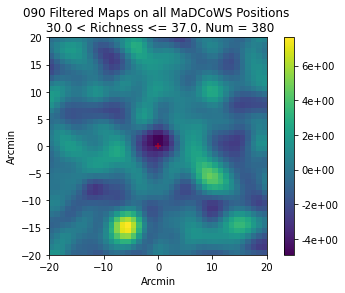

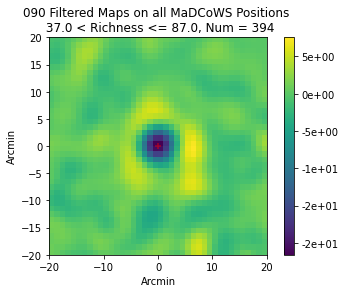

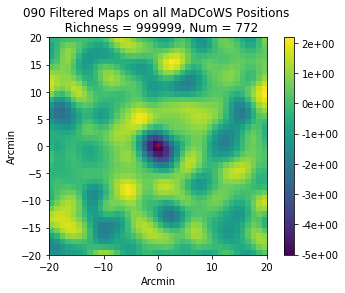

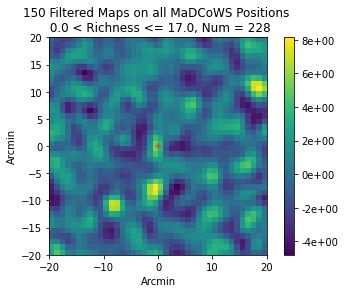

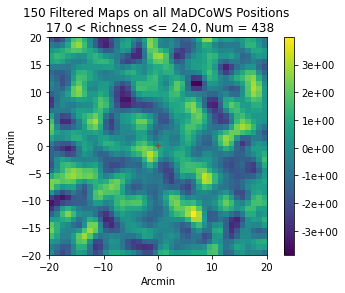

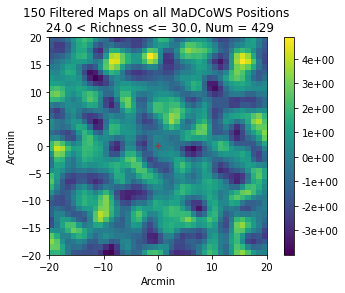

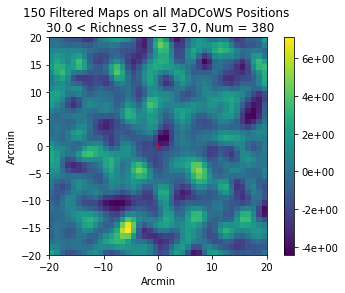

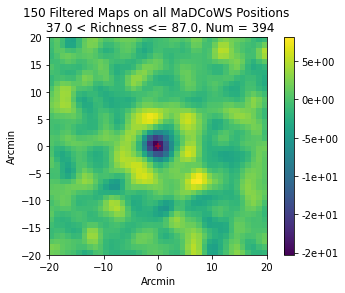

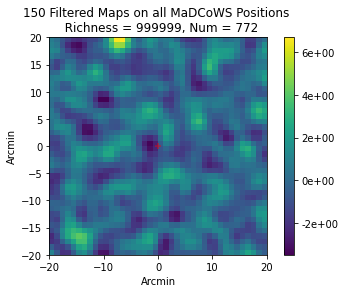

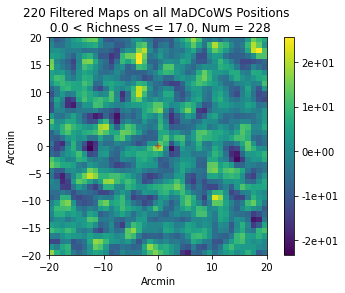

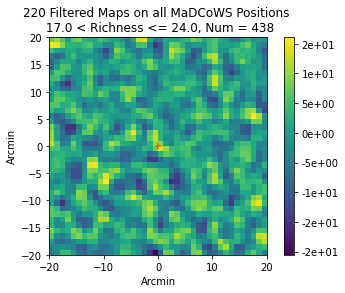

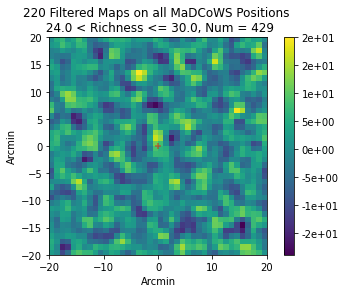

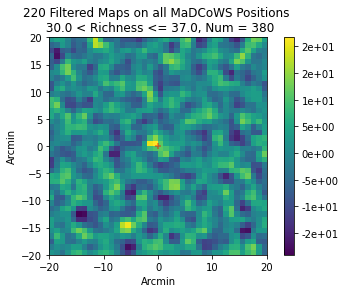

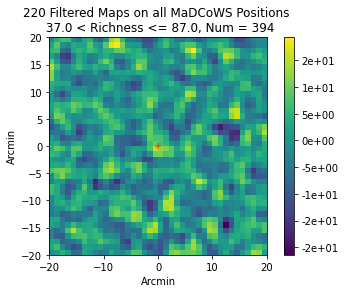

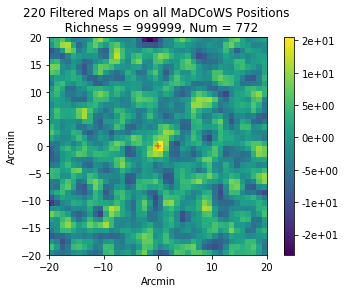

In [58]:
mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')

ra = mdcw_catalog[1].data['RADeg']
names = mdcw_catalog[1].data['name']
dec = mdcw_catalog[1].data['decDeg']
ra, dec = np.array(ra), np.array(dec)
rich = mdcw_catalog[1].data['Rich']
z = mdcw_catalog[1].data['Photz']


mdcw_freq_dict = {'090':{}, '150':{}, '220':{}}

flag = np.where((rich != 999999))[0]
flag2 = np.where((rich == 999999))
ra2, dec2 = ra[flag2], dec[flag2]
ra, dec, rich = ra[flag], dec[flag], rich[flag]

nbins = 5
perc = np.percentile(rich, np.linspace(0,100, nbins+1)) 

perc[0] = perc[0]*0.99

for i, (freq, cur_dict) in enumerate(mdcw_freq_dict.items()):    
    
    cur_dict['central_t'] = []
    cur_dict['highest_t'] = []
    cur_dict['map_var'] = []
    
    cur_map = enmap.read_map('/gpfs/fs0/project/r/rbond/jorlo/freq_maps/stitched_Beam{}_filteredMap.fits'.format(str(freq)))
    
    #for j in range(0,70, 10):
    for j in range(nbins):
        flag = np.where((rich>perc[j]) & (rich<=perc[j+1]))[0]
        if len(flag) == 0: continue

        ra_temp, dec_temp = ra[flag], dec[flag]

        stack = 0
        divisor = 0

        for k in range(len(ra_temp)):
            stamp = reproject.postage_stamp(cur_map, ra_temp[k], dec_temp[k], 20., 0.5)
            if stamp is None: continue
            stack += stamp[0]
            divisor += 1

        stack /= divisor

        plot = plt.imshow(stack, extent = [-20, 20, -20, 20])
        plt.scatter(0,0, marker = '+', color = 'r', alpha = 0.5)
        plt.colorbar(plot, format='%.0e')
        plt.title('{} Filtered Maps on all MaDCoWS Positions \n {} < Richness <= {}, Num = {}'.format(freq,perc[j], perc[j+1],len(flag)))

        plt.xlabel('Arcmin')
        plt.ylabel('Arcmin')
        plt.savefig('./plots/PS_freq/mdcw_{}_{}_filtered_mdcw.pdf'.format(j, freq))
        plt.savefig('./plots/PS_freq/mdcw_{}_{}_filtered_mdcw.png'.format(j, freq), dpi = 300)
        plt.show()
        plt.close()

        cur_dict['highest_t'].append(np.amin(stack[19:31,19:31]))
        cur_dict['central_t'].append(np.mean(stack[19:21, 19:21]))

        cur_dict['map_var'].append(np.sqrt(np.var(stack[0:15, 0:15])))
    
    stack = 0
    divisor = 0

    for k in range(len(ra2)):
        stamp = reproject.postage_stamp(cur_map, ra2[k], dec2[k], 20., 0.5)
        if stamp is None: continue
        stack += stamp[0]
        divisor += 1

    stack /= divisor

    plot = plt.imshow(stack, extent = [-20, 20, -20, 20])
    plt.scatter(0,0, marker = '+', color = 'r', alpha = 0.5)
    plt.colorbar(plot, format='%.0e')
    plt.title('{} Filtered Maps on all MaDCoWS Positions \n  Richness = 999999, Num = {}'.format(freq,len(ra2)))

    plt.xlabel('Arcmin')
    plt.ylabel('Arcmin')
    plt.savefig('./plots/PS_freq/mdcw_{}_{}_filtered_mdcw.pdf'.format(999999, freq))
    plt.savefig('./plots/PS_freq/mdcw_{}_{}_filtered_mdcw.png'.format(999999, freq), dpi = 300)
    plt.show()
    plt.close()

    cur_dict['highest_t'].append(np.amin(stack[19:31,19:31]))
    cur_dict['central_t'].append(np.mean(stack[19:21, 19:21]))

    cur_dict['map_var'].append(np.sqrt(np.var(stack[0:15, 0:15])))

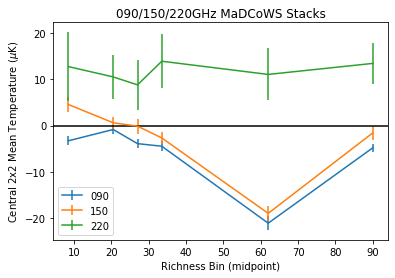

In [59]:
xrange = []
for i in range(nbins):
    xrange.append((perc[i]+perc[i+1])/2)


xrange.append(90)
for i, (freq, cur_dict) in enumerate(mdcw_freq_dict.items()):    
    plt.errorbar(xrange, cur_dict['central_t'], yerr = cur_dict['map_var'], label = freq)

plt.legend()
plt.title(r'090/150/220GHz MaDCoWS Stacks')
plt.xlabel('Richness Bin (midpoint)')
plt.ylabel(r'Central 2x2 Mean Temperature ($\mu$K)')
plt.axhline(y=0, color='k')

plt.savefig('./plots/PS_freq/mdcw_rich_central_temp.pdf')
plt.savefig('./plots/PS_freq/mdcw_rich_central_temp.png', dpi = 300)
plt.show()
plt.close()

# Estimate of 220 over all madcows clusters

In [67]:
mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')

cur_map = enmap.read_map('/gpfs/fs0/project/r/rbond/jorlo/freq_maps/stitched_Beam220_filteredMap.fits')


ra = mdcw_catalog[1].data['RADeg']
names = mdcw_catalog[1].data['name']
dec = mdcw_catalog[1].data['decDeg']
ra, dec = np.array(ra), np.array(dec)
rich = mdcw_catalog[1].data['Rich']
z = mdcw_catalog[1].data['Photz']

central_t_jk = []

num_jk = 200

chunks = np.array_split(range(len(ra)),num_jk)  


for j in range(int(num_jk)):
    print('{}\r'.format(j),)

    ra_temp = np.delete(ra, chunks[j])
    dec_temp = np.delete(dec, chunks[j])
    
    stack = 0
    divisor = 0

    for k in range(len(ra_temp)):
        stamp = reproject.postage_stamp(cur_map, ra_temp[k], dec_temp[k], 20., 0.5)
        if stamp is None: continue
        stack += stamp[0]
        divisor += 1

    stack /= divisor
    central_t_jk.append(np.mean(stack[19:21, 19:21]))
    

central_t_boot = []

for j in range(200):
    print('Bootstraps')
    print('{}\r'.format(j),)
    flags = np.random.randint(len(ra), size = len(ra))
    
    ra_temp, dec_temp = ra[flags], dec[flags]
    
    stack = 0
    divisor = 0

    for k in range(len(ra_temp)):
        stamp = reproject.postage_stamp(cur_map, ra_temp[k], dec_temp[k], 20., 0.5)
        if stamp is None: continue
        stack += stamp[0]
        divisor += 1

    stack /= divisor
    central_t_boot.append(np.mean(stack[19:21, 19:21]))
    
print('220jk = {} +/- {}'.format(np.mean(central_t_jk), np.var(central_t_jk)))
print('220boot = {} +/- {}'.format(np.mean(central_t_boot), np.var(central_t_boot)))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
Bootstraps
0
Bootstraps
1
Bootstraps
2
Bootstraps
3
Bootstraps
4
Bootstraps
5
Bootstraps
6
Bootstraps
7
Bootstraps
8
Bootstraps
9
Bootstraps
10
Bootstraps
11
Bootstraps
12
Bootstraps
13
Bootstraps
14
Bootstraps
15
Bootstraps
16
Bootstraps
17
Bootstraps
18
Bootstraps
19
Bootstraps
20
Bootstraps
21
Bootstraps
2

In [69]:
act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')
cur_map = enmap.read_map('/gpfs/fs0/project/r/rbond/jorlo/freq_maps/stitched_Beam220_filteredMap.fits')

ra = act_catalog[1].data['RADeg']
names = act_catalog[1].data['name']
dec = act_catalog[1].data['decDeg']
ra, dec = np.array(ra), np.array(dec)
mass = act_catalog[1].data['M500']

central_t_jk = []

num_jk = 50

chunks = np.array_split(range(len(ra)),num_jk)  


for j in range(int(num_jk)):
    print('{}\r'.format(j),)

    ra_temp = np.delete(ra, chunks[j])
    dec_temp = np.delete(dec, chunks[j])
    
    stack = 0
    divisor = 0

    for k in range(len(ra_temp)):
        stamp = reproject.postage_stamp(cur_map, ra_temp[k], dec_temp[k], 20., 0.5)
        if stamp is None: continue
        stack += stamp[0]
        divisor += 1

    stack /= divisor
    central_t_jk.append(np.mean(stack[19:21, 19:21]))
    

central_t_boot = []

for j in range(50):
    print('Bootstraps')
    print('{}\r'.format(j),)
    flags = np.random.randint(len(ra), size = len(ra))
    
    ra_temp, dec_temp = ra[flags], dec[flags]
    
    stack = 0
    divisor = 0

    for k in range(len(ra_temp)):
        stamp = reproject.postage_stamp(cur_map, ra_temp[k], dec_temp[k], 20., 0.5)
        if stamp is None: continue
        stack += stamp[0]
        divisor += 1

    stack /= divisor
    central_t_boot.append(np.mean(stack[19:21, 19:21]))
    
print('220jk = {} +/- {}'.format(np.mean(central_t_jk), np.sqrt(np.var(central_t_jk))))
print('220boot = {} +/- {}'.format(np.mean(central_t_boot), np.sqrt(np.var(central_t_boot))))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
Bootstraps
0
Bootstraps
1
Bootstraps
2
Bootstraps
3
Bootstraps
4
Bootstraps
5
Bootstraps
6
Bootstraps
7
Bootstraps
8
Bootstraps
9
Bootstraps
10
Bootstraps
11
Bootstraps
12
Bootstraps
13
Bootstraps
14
Bootstraps
15
Bootstraps
16
Bootstraps
17
Bootstraps
18
Bootstraps
19
Bootstraps
20
Bootstraps
21
Bootstraps
22
Bootstraps
23
Bootstraps
24
Bootstraps
25
Bootstraps
26
Bootstraps
27
Bootstraps
28
Bootstraps
29
Bootstraps
30
Bootstraps
31
Bootstraps
32
Bootstraps
33
Bootstraps
34
Bootstraps
35
Bootstraps
36
Bootstraps
37
Bootstraps
38
Bootstraps
39
Bootstraps
40
Bootstraps
41
Bootstraps
42
Bootstraps
43
Bootstraps
44
Bootstraps
45
Bootstraps
46
Bootstraps
47
Bootstraps
48
Bootstraps
49
220jk = -3.0844004449292157 +/- 0.16810488746440275
220boot = -3.0892864832116462 +/- 1.2395848709717763


In [14]:
act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')
cur_map = enmap.read_map('/gpfs/fs0/project/r/rbond/jorlo/freq_maps/stitched_Beam220_filteredMap.fits')

ra = act_catalog[1].data['RADeg']
names = act_catalog[1].data['name']
dec = act_catalog[1].data['decDeg']
ra, dec = np.array(ra), np.array(dec)
mass = act_catalog[1].data['M500']
z = act_catalog[1].data['redshift']


"""
central_t_jk = []

num_jk = 50

chunks = np.array_split(range(len(ra)),num_jk)  


for j in range(int(num_jk)):
    print('{} \r'.format(j),)

    ra_temp = np.delete(ra, chunks[j])
    dec_temp = np.delete(dec, chunks[j])
    
    stack = 0
    divisor = 0

    for k in range(len(ra_temp)):
        stamp = reproject.postage_stamp(cur_map, ra_temp[k], dec_temp[k], 20., 0.5)
        if stamp is None: continue
        stack += stamp[0]
        divisor += 1

    stack /= divisor
    central_t_jk.append(np.mean(stack[19:21, 19:21]))
    
"""
zs = np.arange(0, 1.4, 0.2)

signals = []
errors = []

for i in zs:
    print(i)

    flag = np.where((z>=i) & (z<i+0.2))[0]

    ra_temp, dec_temp = ra[flag], dec[flag]

    central_t_boot = []

    for j in range(50):
        print(j, end='\r')
        flags = np.random.randint(len(ra_temp), size = len(ra_temp))

        ra_temp2, dec_temp2 = ra_temp[flags], dec_temp[flags]

        stack = 0
        divisor = 0

        for k in range(len(ra_temp2)):
            stamp = reproject.postage_stamp(cur_map, ra_temp2[k], dec_temp2[k], 20., 0.5)
            if stamp is None: continue
            stack += stamp[0]
            divisor += 1

        stack /= divisor
        central_t_boot.append(np.mean(stack[19:21, 19:21]))

    #print('220jk = {} +/- {}'.format(np.mean(central_t_jk), np.sqrt(np.var(central_t_jk))))
    signals.append(np.mean(central_t_boot))
    errors.append(np.sqrt(np.var(central_t_boot)))

0.0
0.2
0.4
0.6000000000000001
0.8
1.0
1.2000000000000002


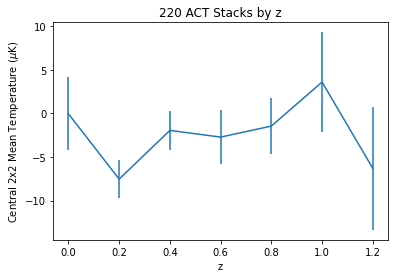

In [16]:
plt.errorbar(zs, signals, yerr=errors)
plt.title(r'220 ACT Stacks by z')
plt.xlabel('z')
plt.ylabel(r'Central 2x2 Mean Temperature ($\mu$K)')

plt.savefig('./plots/PS_freq/act_z_central_temp.pdf')
plt.savefig('./plots/PS_freq/act_z_central_temp.png', dpi = 300)
plt.show()
plt.close()

In [18]:
act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')
cur_map = enmap.read_map('/gpfs/fs0/project/r/rbond/jorlo/freq_maps/stitched_Beam220_filteredMap.fits')

ra = act_catalog[1].data['RADeg']
names = act_catalog[1].data['name']
dec = act_catalog[1].data['decDeg']
ra, dec = np.array(ra), np.array(dec)
mass = act_catalog[1].data['M500']
z = act_catalog[1].data['redshift']


flag = np.where((z>0.7))[0]

ra_temp, dec_temp = ra[flag], dec[flag]

central_t_boot = []

for j in range(50):
    print(j, end='\r')
    flags = np.random.randint(len(ra), size = len(ra))
    
    ra_temp, dec_temp = ra[flags], dec[flags]
    
    stack = 0
    divisor = 0

    for k in range(len(ra_temp)):
        stamp = reproject.postage_stamp(cur_map, ra_temp[k], dec_temp[k], 20., 0.5)
        if stamp is None: continue
        stack += stamp[0]
        divisor += 1

    stack /= divisor
    central_t_boot.append(np.mean(stack[19:21, 19:21]))

print('220boot = {} +/- {}'.format(np.mean(central_t_boot), np.sqrt(np.var(central_t_boot))))

220boot = -2.868107278444128 +/- 1.3329470771982188


# Central brightness distribution

In [92]:
with open('/project/r/rbond/jorlo/S18d_202006/selFn/tileDefinitions.yml') as f:
    
    s18d = yaml.load(f)
    
mdcw_catalog = fits.open('/home/s/sievers/sdicker/ACTnCOWs/MADCOWSUnion.fits')

ra = mdcw_catalog[1].data['RADeg']
names = mdcw_catalog[1].data['name']
dec = mdcw_catalog[1].data['decDeg']
ra, dec = np.array(ra), np.array(dec)
rich = mdcw_catalog[1].data['Rich']
z = mdcw_catalog[1].data['Photz']

#flags = np.where((30<= rich) & (rich <=40))[0]

#ra, dec, names, rich = ra[flags], dec[flags], names[flags], rich[flags]

lowest_y = []
central_y = []

for i in range(len(ra)):
    stamp = s18dStamp(ra[i], dec[i], s18d, 'fakename', width = 0.5, write = False)
    if stamp is None: 
        lowest_y.append(0)
        central_y.append(0)
        continue
    lowest_y.append(np.amin(stamp[0][29:31, 29:31]))
    central_y.append(np.mean(stamp[0][29:31, 29:31]))

sort_names =  [x for y, x in sorted(zip(central_y, names))]
sort_lowest_y = [x for y, x in sorted(zip(central_y, lowest_y))]
sort_central_y = sorted(central_y)

flags = np.where((sort_central_y != 0))[0]
print(flags)

sort_central_y = [x for x in sort_central_y if x != 0]
sort_lowest_y = [x for x in sort_lowest_y if x != 0]
sort_names[flags]

fig = plt.figure()
plt.ylabel('Central Comptonization')

#plt.plot(range(len(sort_lowest_y)), sort_lowest_y, label = 'Lowest pixel in central 2x2')
plt.plot(range(len(sort_lowest_y)), sort_central_y, label = 'Average of central 2x2')
plt.legend()

plt.title(r'Central brightness of MaDCoWS clusters')
plt.savefig('./plots/low_y/full_distribution.pdf')
plt.savefig('./plots/low_y/full_distribution.png', dpi = 300)

/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


[0]


TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
n, bins, patches = plt.hist(sort_central_y, bins=25, density=False, alpha=0.6, color='g')

mu, std = norm.fit(sort_central_y)

#xmin, xmax = plt.xlim()
#x = np.linspace(xmin, xmax, 100)
#p = norm.pdf(x, mu, std)
#plt.plot(x, p, 'k', linewidth=2)
plt.title('Distribution of Central Comptonization in 2x2 Pixels, all MaDCoWS')
plt.xlabel('Central Comptonization')
plt.ylabel('Count')
plt.savefig('./plots/full_central_y_dist.pdf')
plt.savefig('./plots/full_central_y_dist.png', dpi = 300)
plt.show()

In [ ]:

print(mu, std)

In [ ]:
print(sort_central_y[:10])
print(sort_names[:10])

In [ ]:
np.where(sort_names== 'MOO J0936+0336')


In [ ]:
print(sort_names)